## 範例重點

了解如何在 Keras 中，加入 regularization

熟悉建立、訓練模型

熟悉將訓練結果視覺化並比較結果

In [1]:
import keras
import os

# GPU 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer) # regularization
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x) # regularization
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0721 20:08:18.172437 4647654848 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0721 20:08:18.199876 4647654848 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0721 20:08:18.322386 4647654848 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 20:08:18.331336 4647654848 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/back

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0721 20:08:18.697165 4647654848 deprecation.py:323] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 23s 458us/step - loss: 15.1055 - acc: 0.2654 - val_loss: 13.9793 - val_acc: 0.3351
Epoch 2/50
50000/50000 [==============================] - 12s 242us/step - loss: 13.0354 - acc: 0.3554 - val_loss: 12.1360 - val_acc: 0.3761
Epoch 3/50
50000/50000 [==============================] - 10s 201us/step - loss: 11.3563 - acc: 0.3797 - val_loss: 10.6088 - val_acc: 0.3867
Epoch 4/50
50000/50000 [==============================] - 8s 168us/step - loss: 9.9403 - acc: 0.3966 - val_loss: 9.3039 - val_acc: 0.4031
Epoch 5/50
50000/50000 [==============================] - 8s 156us/step - loss: 8.7375 - acc: 0.4059 - val_loss: 8.1943 - val_acc: 0.4099
Epoch 6/50
50000/50000 [==============================] - 7s 148us/step - loss: 7.7129 - acc: 0.4167 - val_loss: 7.2488 - val_acc: 0.4207
Epoch 7/50
50000/50000 [==============================] - 7s 143us/step - loss: 6.8402 - acc: 0.4219 - val_loss: 

/Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113644). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 17s 333us/step - loss: 1.0551 - acc: 0.6783 - val_loss: 1.5437 - val_acc: 0.5236
Epoch 50/50
50000/50000 [==============================] - 19s 380us/step - loss: 1.0427 - acc: 0.6812 - val_loss: 1.5964 - val_acc: 0.5167
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None,

Epoch 50/50
50000/50000 [==============================] - 37s 735us/step - loss: 0.8776 - acc: 0.6941 - val_loss: 1.4613 - val_acc: 0.5196
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_____________________

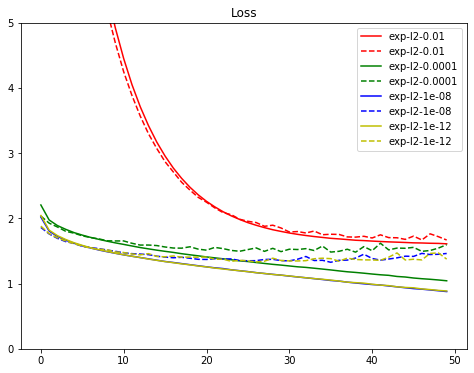

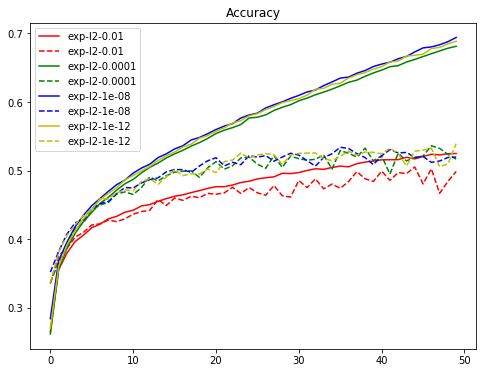

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()


## Work

1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [9]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 140us/step - loss: 2.4635 - acc: 0.0957 - val_loss: 2.3036 - val_acc: 0.0997
Epoch 2/50
50000/50000 [==============================] - 7s 146us/step - loss: 2.3035 - acc: 0.0999 - val_loss: 2.3033 - val_acc: 0.1007
Epoch 3/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.3032 - acc: 0.0975 - val_loss: 2.3031 - val_acc: 0.1008
Epoch 4/50
50000/50000 [==============================] - 7s 139us/step - loss: 2.3031 - acc: 0.0974 - val_loss: 2.3030 - val_acc: 0.1010
Epoch 5/50
50000/50000 [==============================] - 7s 143us/step - loss: 2.3030 - acc: 0.0973 - val_loss: 2.3030 - val_acc: 0.1006
Epoch 6/50
50000/50000 [==============================] - 7s 149us/step - loss: 2.3030 - acc: 0.0962 - val_loss: 2.3029 - val_acc: 0.1003
Epoch 7/50
50000/50000 [==============================] - 7s 147us/step - loss: 2.3029 - acc: 0.0998 - val_loss: 2.3029 - 

Epoch 2/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.8078 - acc: 0.3679 - val_loss: 1.7582 - val_acc: 0.3881
Epoch 3/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.7245 - acc: 0.3967 - val_loss: 1.7019 - val_acc: 0.3999
Epoch 4/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.6686 - acc: 0.4158 - val_loss: 1.6475 - val_acc: 0.4243
Epoch 5/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.6228 - acc: 0.4300 - val_loss: 1.6090 - val_acc: 0.4311
Epoch 6/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.5834 - acc: 0.4448 - val_loss: 1.5757 - val_acc: 0.4466
Epoch 7/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.5484 - acc: 0.4550 - val_loss: 1.5627 - val_acc: 0.4460- ETA: 0s - loss: 1.5499 - 
Epoch 8/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.5191 - acc: 0.4668 - val_loss: 1.5336 - val_acc: 0.4566
Epoch 9

Epoch 3/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.7141 - acc: 0.3990 - val_loss: 1.6852 - val_acc: 0.4095
Epoch 4/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.6574 - acc: 0.4199 - val_loss: 1.6438 - val_acc: 0.4309
Epoch 5/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.6111 - acc: 0.4353 - val_loss: 1.6043 - val_acc: 0.4369
Epoch 6/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.5700 - acc: 0.4505 - val_loss: 1.5723 - val_acc: 0.4430
Epoch 7/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.5375 - acc: 0.4610 - val_loss: 1.5361 - val_acc: 0.4627
Epoch 8/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.5050 - acc: 0.4716 - val_loss: 1.5160 - val_acc: 0.4675
Epoch 9/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.4779 - acc: 0.4816 - val_loss: 1.4880 - val_acc: 0.4778
Epoch 10/50
50000/50000 [=========

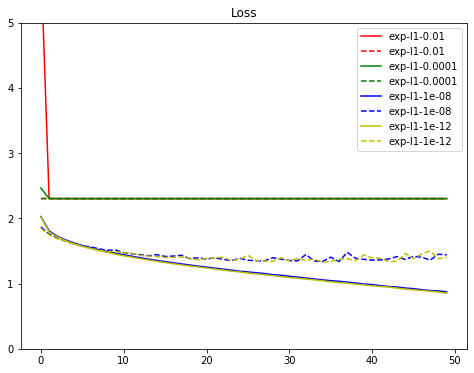

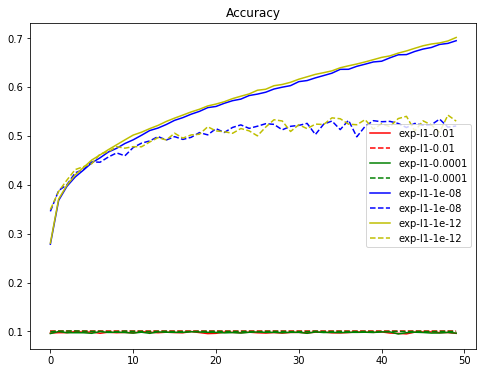

In [13]:
train, test = keras.datasets.cifar10.load_data()




## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y   




x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)




from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   activity_regularizer=l1(l1_ratio))(input_layer) # regularization
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   activity_regularizer=l1(l1_ratio))(x) # regularization
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model




## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]




results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    
    

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
  768/50000 [..............................] - ETA: 3:19 - loss: 20.2875 - acc: 0.0911

/Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128133). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 72s 1ms/step - loss: 18.8116 - acc: 0.2767 - val_loss: 17.3730 - val_acc: 0.3406
Epoch 2/50
50000/50000 [==============================] - 41s 827us/step - loss: 16.1581 - acc: 0.3527 - val_loss: 14.9972 - val_acc: 0.3688
Epoch 3/50
50000/50000 [==============================] - 25s 502us/step - loss: 13.9746 - acc: 0.3771 - val_loss: 12.9955 - val_acc: 0.3815
Epoch 4/50
50000/50000 [==============================] - 14s 275us/step - loss: 12.1253 - acc: 0.3889 - val_loss: 11.2899 - val_acc: 0.3925
Epoch 5/50
50000/50000 [==============================] - 12s 236us/step - loss: 10.5529 - acc: 0.3996 - val_loss: 9.8458 - val_acc: 0.3996
Epoch 6/50
50000/50000 [==============================] - 10s 209us/step - loss: 9.2141 - acc: 0.4073 - val_loss: 8.6059 - val_acc: 0.4121
Epoch 7/50
50000/50000 [==============================] - 12s 238us/step - loss: 8.0728 - acc: 0.4113 - val_loss: 7.5582 - val_acc: 0.4146
Epoch 8/50
50000/50000 [=======

Epoch 2/50
50000/50000 [==============================] - 9s 180us/step - loss: 12.9878 - acc: 0.3660 - val_loss: 12.1008 - val_acc: 0.3769
Epoch 3/50
50000/50000 [==============================] - 9s 181us/step - loss: 11.3175 - acc: 0.3873 - val_loss: 10.5754 - val_acc: 0.3930
Epoch 4/50
50000/50000 [==============================] - 10s 200us/step - loss: 9.9073 - acc: 0.4012 - val_loss: 9.2751 - val_acc: 0.4032
Epoch 5/50
50000/50000 [==============================] - 9s 189us/step - loss: 8.7094 - acc: 0.4149 - val_loss: 8.1774 - val_acc: 0.4120
Epoch 6/50
50000/50000 [==============================] - 10s 191us/step - loss: 7.6908 - acc: 0.4203 - val_loss: 7.2428 - val_acc: 0.4095
Epoch 7/50
50000/50000 [==============================] - 10s 209us/step - loss: 6.8191 - acc: 0.4288 - val_loss: 6.4282 - val_acc: 0.4306
Epoch 8/50
50000/50000 [==============================] - 10s 200us/step - loss: 6.0775 - acc: 0.4343 - val_loss: 5.7543 - val_acc: 0.4338
Epoch 9/50
50000/50000 [==

Epoch 3/50
50000/50000 [==============================] - 10s 203us/step - loss: 11.3340 - acc: 0.3839 - val_loss: 10.5835 - val_acc: 0.3991
Epoch 4/50
50000/50000 [==============================] - 10s 209us/step - loss: 9.9221 - acc: 0.4006 - val_loss: 9.2905 - val_acc: 0.4033
Epoch 5/50
50000/50000 [==============================] - 16s 323us/step - loss: 8.7233 - acc: 0.4101 - val_loss: 8.1785 - val_acc: 0.4103
Epoch 6/50
50000/50000 [==============================] - 31s 629us/step - loss: 7.7008 - acc: 0.4192 - val_loss: 7.2377 - val_acc: 0.4193
Epoch 7/50
50000/50000 [==============================] - 13s 252us/step - loss: 6.8292 - acc: 0.4239 - val_loss: 6.4373 - val_acc: 0.4263
Epoch 8/50
50000/50000 [==============================] - 12s 236us/step - loss: 6.0843 - acc: 0.4307 - val_loss: 5.7514 - val_acc: 0.4325
Epoch 9/50
50000/50000 [==============================] - 13s 269us/step - loss: 5.4504 - acc: 0.4353 - val_loss: 5.1708 - val_acc: 0.4337
Epoch 10/50
50000/50000 [

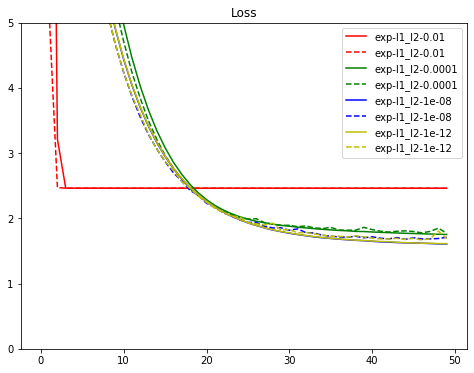

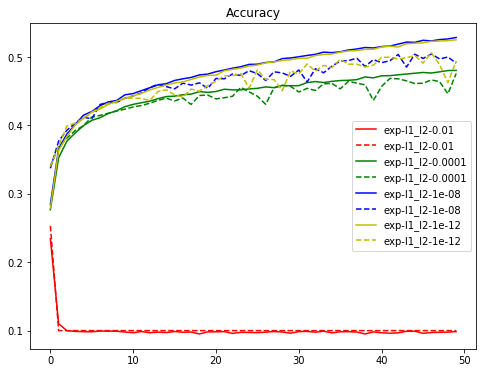

In [14]:
train, test = keras.datasets.cifar10.load_data()




## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y   




x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)




# from keras import regularizers
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer) # regularization
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x) # regularization
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model




## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]




results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    
    

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 看過 ANS 後改一版

Using TensorFlow backend.
W0722 21:03:54.199979 4600071616 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0722 21:03:54.204358 4600071616 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0722 21:03:54.259028 4600071616 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 21:03:54.262020 4600071616 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.

Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0722 21:03:54.579098 4600071616 deprecation.py:323] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 159us/step - loss: 197.9235 - acc: 0.2360 - val_loss: 36.0639 - val_acc: 0.2368
Epoch 2/50
50000/50000 [==============================] - 7s 138us/step - loss: 15.9986 - acc: 0.1077 - val_loss: 5.1852 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 7s 149us/step - loss: 3.2318 - acc: 0.0988 - val_loss: 2.4717 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 9s 184us/step - loss: 2.4631 - acc: 0.0982 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.4624 - acc: 0.0971 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 9s 175us/step - loss: 2.4624 - acc: 0.0982 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 8s 161us/step - loss: 2.4624 - acc: 0.1004 - val_loss: 2.462

50000/50000 [==============================] - 10s 199us/step - loss: 198.6074 - acc: 0.2462 - val_loss: 40.9976 - val_acc: 0.2849
Epoch 2/50
50000/50000 [==============================] - 14s 281us/step - loss: 19.0349 - acc: 0.1192 - val_loss: 7.2523 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 11s 224us/step - loss: 4.0941 - acc: 0.0995 - val_loss: 2.6421 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 10s 204us/step - loss: 2.4855 - acc: 0.0973 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 10s 202us/step - loss: 2.4626 - acc: 0.0979 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.4626 - acc: 0.0984 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 7s 136us/step - loss: 2.4626 - acc: 0.0993 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 8/50
50000/50000 [============

50000/50000 [==============================] - 8s 170us/step - loss: 19.0962 - acc: 0.1164 - val_loss: 7.2742 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 8s 154us/step - loss: 4.0952 - acc: 0.0993 - val_loss: 2.6419 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 7s 131us/step - loss: 2.4852 - acc: 0.0981 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 6s 128us/step - loss: 2.4626 - acc: 0.0973 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 6s 120us/step - loss: 2.4626 - acc: 0.0961 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 6s 120us/step - loss: 2.4626 - acc: 0.0977 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 7s 136us/step - loss: 2.4626 - acc: 0.0966 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 9/50
50000/50000 [====================

Epoch 3/50
50000/50000 [==============================] - 12s 236us/step - loss: 4.1048 - acc: 0.1000 - val_loss: 2.6456 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 11s 216us/step - loss: 2.4855 - acc: 0.1002 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 11s 222us/step - loss: 2.4626 - acc: 0.0985 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 11s 217us/step - loss: 2.4626 - acc: 0.0991 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 9s 183us/step - loss: 2.4626 - acc: 0.0985 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 6s 122us/step - loss: 2.4626 - acc: 0.0963 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 6s 118us/step - loss: 2.4626 - acc: 0.0974 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 10/50
50000/50000 [=====

50000/50000 [==============================] - 6s 116us/step - loss: 2.4871 - acc: 0.0977 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 6s 126us/step - loss: 2.4626 - acc: 0.0956 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 6s 117us/step - loss: 2.4626 - acc: 0.0990 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.4626 - acc: 0.0974 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 6s 130us/step - loss: 2.4626 - acc: 0.0986 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.4626 - acc: 0.0975 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 6s 129us/step - loss: 2.4626 - acc: 0.0981 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 11/50
50000/50000 [===================

50000/50000 [==============================] - 8s 155us/step - loss: 10.5272 - acc: 0.3983 - val_loss: 9.8265 - val_acc: 0.4041
Epoch 6/50
50000/50000 [==============================] - 7s 133us/step - loss: 9.1921 - acc: 0.4052 - val_loss: 8.5890 - val_acc: 0.4119
Epoch 7/50
50000/50000 [==============================] - 7s 137us/step - loss: 8.0555 - acc: 0.4115 - val_loss: 7.5405 - val_acc: 0.4174
Epoch 8/50
50000/50000 [==============================] - 7s 147us/step - loss: 7.0874 - acc: 0.4158 - val_loss: 6.6579 - val_acc: 0.4165
Epoch 9/50
50000/50000 [==============================] - 7s 136us/step - loss: 6.2627 - acc: 0.4199 - val_loss: 5.8969 - val_acc: 0.4193
Epoch 10/50
50000/50000 [==============================] - 8s 168us/step - loss: 5.5611 - acc: 0.4226 - val_loss: 5.2442 - val_acc: 0.4268
Epoch 11/50
50000/50000 [==============================] - 8s 169us/step - loss: 4.9632 - acc: 0.4256 - val_loss: 4.6931 - val_acc: 0.4331
Epoch 12/50
50000/50000 [=================

50000/50000 [==============================] - 8s 155us/step - loss: 5.3350 - acc: 0.4497 - val_loss: 5.3139 - val_acc: 0.4452
Epoch 7/50
50000/50000 [==============================] - 9s 176us/step - loss: 5.2355 - acc: 0.4602 - val_loss: 5.2050 - val_acc: 0.4570
Epoch 8/50
50000/50000 [==============================] - 7s 147us/step - loss: 5.1417 - acc: 0.4695 - val_loss: 5.1298 - val_acc: 0.4600
Epoch 9/50
50000/50000 [==============================] - 9s 190us/step - loss: 5.0520 - acc: 0.4767 - val_loss: 5.0432 - val_acc: 0.4592
Epoch 10/50
50000/50000 [==============================] - 7s 146us/step - loss: 4.9627 - acc: 0.4860 - val_loss: 4.9546 - val_acc: 0.4736
Epoch 11/50
50000/50000 [==============================] - 7s 136us/step - loss: 4.8770 - acc: 0.4938 - val_loss: 4.8866 - val_acc: 0.4738
Epoch 12/50
50000/50000 [==============================] - 6s 130us/step - loss: 4.7951 - acc: 0.4996 - val_loss: 4.7972 - val_acc: 0.4826
Epoch 13/50
50000/50000 [=================

50000/50000 [==============================] - 7s 140us/step - loss: 5.1551 - acc: 0.4538 - val_loss: 5.1241 - val_acc: 0.4522
Epoch 8/50
50000/50000 [==============================] - 7s 134us/step - loss: 5.0623 - acc: 0.4646 - val_loss: 5.0410 - val_acc: 0.4603
Epoch 9/50
50000/50000 [==============================] - 7s 135us/step - loss: 4.9733 - acc: 0.4746 - val_loss: 4.9493 - val_acc: 0.4676
Epoch 10/50
50000/50000 [==============================] - 7s 134us/step - loss: 4.8884 - acc: 0.4813 - val_loss: 4.8755 - val_acc: 0.4758
Epoch 11/50
50000/50000 [==============================] - 7s 136us/step - loss: 4.8059 - acc: 0.4887 - val_loss: 4.8092 - val_acc: 0.4706
Epoch 12/50
50000/50000 [==============================] - 8s 157us/step - loss: 4.7256 - acc: 0.4973 - val_loss: 4.7261 - val_acc: 0.4822
Epoch 13/50
50000/50000 [==============================] - 8s 155us/step - loss: 4.6469 - acc: 0.5024 - val_loss: 4.6704 - val_acc: 0.4770
Epoch 14/50
50000/50000 [================

50000/50000 [==============================] - 14s 276us/step - loss: 5.0741 - acc: 0.4586 - val_loss: 5.0544 - val_acc: 0.4508
Epoch 9/50
50000/50000 [==============================] - 14s 276us/step - loss: 4.9877 - acc: 0.4684 - val_loss: 4.9710 - val_acc: 0.4635
Epoch 10/50
50000/50000 [==============================] - 17s 346us/step - loss: 4.9013 - acc: 0.4769 - val_loss: 4.9020 - val_acc: 0.4600
Epoch 11/50
50000/50000 [==============================] - 17s 348us/step - loss: 4.8193 - acc: 0.4856 - val_loss: 4.8086 - val_acc: 0.4768
Epoch 12/50
50000/50000 [==============================] - 18s 366us/step - loss: 4.7398 - acc: 0.4921 - val_loss: 4.7419 - val_acc: 0.4713
Epoch 13/50
50000/50000 [==============================] - 16s 318us/step - loss: 4.6587 - acc: 0.5004 - val_loss: 4.7114 - val_acc: 0.4630
Epoch 14/50
50000/50000 [==============================] - 15s 292us/step - loss: 4.5833 - acc: 0.5057 - val_loss: 4.5877 - val_acc: 0.4886
Epoch 15/50
50000/50000 [========

Epoch 9/50
50000/50000 [==============================] - 28s 563us/step - loss: 4.9719 - acc: 0.4726 - val_loss: 4.9591 - val_acc: 0.4587
Epoch 10/50
50000/50000 [==============================] - 21s 428us/step - loss: 4.8877 - acc: 0.4805 - val_loss: 4.8816 - val_acc: 0.4716
Epoch 11/50
50000/50000 [==============================] - 22s 448us/step - loss: 4.8067 - acc: 0.4901 - val_loss: 4.8196 - val_acc: 0.4707
Epoch 12/50
50000/50000 [==============================] - 34s 686us/step - loss: 4.7269 - acc: 0.4945 - val_loss: 4.7216 - val_acc: 0.4850
Epoch 13/50
50000/50000 [==============================] - 45s 891us/step - loss: 4.6480 - acc: 0.5041 - val_loss: 4.6719 - val_acc: 0.4792
Epoch 14/50
50000/50000 [==============================] - 29s 582us/step - loss: 4.5739 - acc: 0.5082 - val_loss: 4.5956 - val_acc: 0.4879
Epoch 15/50
50000/50000 [==============================] - 29s 583us/step - loss: 4.4972 - acc: 0.5153 - val_loss: 4.5173 - val_acc: 0.4951
Epoch 16/50
50000/500

50000/50000 [==============================] - 10s 192us/step - loss: 5.4708 - acc: 0.4250 - val_loss: 5.1981 - val_acc: 0.4197
Epoch 10/50
50000/50000 [==============================] - 10s 194us/step - loss: 4.9288 - acc: 0.4282 - val_loss: 4.6893 - val_acc: 0.4295
Epoch 11/50
50000/50000 [==============================] - 9s 189us/step - loss: 4.4613 - acc: 0.4351 - val_loss: 4.2514 - val_acc: 0.4395
Epoch 12/50
50000/50000 [==============================] - 9s 190us/step - loss: 4.0645 - acc: 0.4398 - val_loss: 3.8914 - val_acc: 0.4403
Epoch 13/50
50000/50000 [==============================] - 9s 188us/step - loss: 3.7231 - acc: 0.4447 - val_loss: 3.5754 - val_acc: 0.4444
Epoch 14/50
50000/50000 [==============================] - 9s 189us/step - loss: 3.4315 - acc: 0.4462 - val_loss: 3.3151 - val_acc: 0.4440
Epoch 15/50
50000/50000 [==============================] - 10s 195us/step - loss: 3.1805 - acc: 0.4517 - val_loss: 3.0791 - val_acc: 0.4509
Epoch 16/50
50000/50000 [===========

50000/50000 [==============================] - 28s 568us/step - loss: 1.6150 - acc: 0.4841 - val_loss: 1.6278 - val_acc: 0.4741
Epoch 10/50
50000/50000 [==============================] - 13s 254us/step - loss: 1.5911 - acc: 0.4895 - val_loss: 1.6156 - val_acc: 0.4751
Epoch 11/50
50000/50000 [==============================] - 24s 482us/step - loss: 1.5663 - acc: 0.4996 - val_loss: 1.6099 - val_acc: 0.4791
Epoch 12/50
50000/50000 [==============================] - 21s 411us/step - loss: 1.5464 - acc: 0.5055 - val_loss: 1.5904 - val_acc: 0.4867
Epoch 13/50
50000/50000 [==============================] - 24s 480us/step - loss: 1.5262 - acc: 0.5118 - val_loss: 1.5701 - val_acc: 0.4938
Epoch 14/50
50000/50000 [==============================] - 27s 549us/step - loss: 1.5037 - acc: 0.5217 - val_loss: 1.5884 - val_acc: 0.4845
Epoch 15/50
50000/50000 [==============================] - 29s 581us/step - loss: 1.4866 - acc: 0.5258 - val_loss: 1.5802 - val_acc: 0.4841
Epoch 16/50
50000/50000 [=======

Epoch 10/50
50000/50000 [==============================] - 10s 204us/step - loss: 1.4768 - acc: 0.4814 - val_loss: 1.5163 - val_acc: 0.4572
Epoch 11/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.4537 - acc: 0.4882 - val_loss: 1.4780 - val_acc: 0.4742
Epoch 12/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.4327 - acc: 0.4953 - val_loss: 1.4836 - val_acc: 0.4750
Epoch 13/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.4116 - acc: 0.5056 - val_loss: 1.4736 - val_acc: 0.4827
Epoch 14/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.3897 - acc: 0.5110 - val_loss: 1.4378 - val_acc: 0.4876
Epoch 15/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.3717 - acc: 0.5183 - val_loss: 1.4257 - val_acc: 0.4910
Epoch 16/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.3524 - acc: 0.5258 - val_loss: 1.4103 - val_acc: 0.4935
Epoch 17/50
50000/5000

Epoch 11/50
50000/50000 [==============================] - 48s 968us/step - loss: 1.4235 - acc: 0.5004 - val_loss: 1.4529 - val_acc: 0.4913
Epoch 12/50
50000/50000 [==============================] - 38s 754us/step - loss: 1.4025 - acc: 0.5064 - val_loss: 1.4442 - val_acc: 0.4880
Epoch 13/50
50000/50000 [==============================] - 13s 265us/step - loss: 1.3782 - acc: 0.5154 - val_loss: 1.4602 - val_acc: 0.4849
Epoch 14/50
50000/50000 [==============================] - 32s 645us/step - loss: 1.3602 - acc: 0.5213 - val_loss: 1.4237 - val_acc: 0.5009
Epoch 15/50
50000/50000 [==============================] - 24s 477us/step - loss: 1.3423 - acc: 0.5258 - val_loss: 1.4184 - val_acc: 0.4982
Epoch 16/50
50000/50000 [==============================] - 38s 764us/step - loss: 1.3238 - acc: 0.5353 - val_loss: 1.4089 - val_acc: 0.4990
Epoch 17/50
50000/50000 [==============================] - 24s 480us/step - loss: 1.3041 - acc: 0.5408 - val_loss: 1.4007 - val_acc: 0.5014
Epoch 18/50
50000/50

Epoch 12/50
50000/50000 [==============================] - 43s 858us/step - loss: 1.4082 - acc: 0.5059 - val_loss: 1.4619 - val_acc: 0.4847
Epoch 13/50
50000/50000 [==============================] - 42s 843us/step - loss: 1.3855 - acc: 0.5130 - val_loss: 1.4502 - val_acc: 0.4847
Epoch 14/50
50000/50000 [==============================] - 30s 596us/step - loss: 1.3670 - acc: 0.5221 - val_loss: 1.4428 - val_acc: 0.4904
Epoch 15/50
50000/50000 [==============================] - 27s 537us/step - loss: 1.3469 - acc: 0.5284 - val_loss: 1.4269 - val_acc: 0.4918
Epoch 16/50
50000/50000 [==============================] - 29s 588us/step - loss: 1.3298 - acc: 0.5337 - val_loss: 1.4151 - val_acc: 0.4920
Epoch 17/50
50000/50000 [==============================] - 56s 1ms/step - loss: 1.3129 - acc: 0.5400 - val_loss: 1.3963 - val_acc: 0.5041
Epoch 18/50
50000/50000 [==============================] - 53s 1ms/step - loss: 1.2952 - acc: 0.5463 - val_loss: 1.3923 - val_acc: 0.5020
Epoch 19/50
50000/50000 

Epoch 13/50
50000/50000 [==============================] - 20s 396us/step - loss: 3.7150 - acc: 0.4474 - val_loss: 3.5682 - val_acc: 0.4445
Epoch 14/50
50000/50000 [==============================] - 19s 373us/step - loss: 3.4227 - acc: 0.4518 - val_loss: 3.2987 - val_acc: 0.4503
Epoch 15/50
50000/50000 [==============================] - 19s 380us/step - loss: 3.1722 - acc: 0.4562 - val_loss: 3.0651 - val_acc: 0.4549
Epoch 16/50
50000/50000 [==============================] - 21s 421us/step - loss: 2.9589 - acc: 0.4591 - val_loss: 2.8752 - val_acc: 0.4487
Epoch 17/50
50000/50000 [==============================] - 11s 211us/step - loss: 2.7749 - acc: 0.4608 - val_loss: 2.7126 - val_acc: 0.4555
Epoch 18/50
50000/50000 [==============================] - 14s 271us/step - loss: 2.6180 - acc: 0.4644 - val_loss: 2.5612 - val_acc: 0.4566
Epoch 19/50
50000/50000 [==============================] - 11s 220us/step - loss: 2.4826 - acc: 0.4664 - val_loss: 2.4290 - val_acc: 0.4638
Epoch 20/50
50000/50

50000/50000 [==============================] - 52s 1ms/step - loss: 1.5269 - acc: 0.5125 - val_loss: 1.6029 - val_acc: 0.4797
Epoch 14/50
50000/50000 [==============================] - 24s 471us/step - loss: 1.5047 - acc: 0.5200 - val_loss: 1.5770 - val_acc: 0.4940
Epoch 15/50
50000/50000 [==============================] - 37s 747us/step - loss: 1.4860 - acc: 0.5244 - val_loss: 1.5613 - val_acc: 0.4953
Epoch 16/50
50000/50000 [==============================] - 28s 551us/step - loss: 1.4671 - acc: 0.5323 - val_loss: 1.5659 - val_acc: 0.4893
Epoch 17/50
50000/50000 [==============================] - 31s 627us/step - loss: 1.4522 - acc: 0.5391 - val_loss: 1.5363 - val_acc: 0.5073
Epoch 18/50
50000/50000 [==============================] - 31s 627us/step - loss: 1.4311 - acc: 0.5444 - val_loss: 1.5233 - val_acc: 0.5041
Epoch 19/50
50000/50000 [==============================] - 26s 515us/step - loss: 1.4145 - acc: 0.5522 - val_loss: 1.5415 - val_acc: 0.5028
Epoch 20/50
50000/50000 [=========

Epoch 14/50
50000/50000 [==============================] - 15s 294us/step - loss: 1.3731 - acc: 0.5166 - val_loss: 1.4276 - val_acc: 0.4948
Epoch 15/50
50000/50000 [==============================] - 14s 281us/step - loss: 1.3527 - acc: 0.5250 - val_loss: 1.4095 - val_acc: 0.5010
Epoch 16/50
50000/50000 [==============================] - 13s 265us/step - loss: 1.3348 - acc: 0.5312 - val_loss: 1.4161 - val_acc: 0.4984
Epoch 17/50
50000/50000 [==============================] - 14s 273us/step - loss: 1.3148 - acc: 0.5382 - val_loss: 1.4084 - val_acc: 0.4993
Epoch 18/50
50000/50000 [==============================] - 16s 318us/step - loss: 1.2980 - acc: 0.5433 - val_loss: 1.4253 - val_acc: 0.4915
Epoch 19/50
50000/50000 [==============================] - 15s 309us/step - loss: 1.2820 - acc: 0.5494 - val_loss: 1.3726 - val_acc: 0.5171
Epoch 20/50
50000/50000 [==============================] - 16s 319us/step - loss: 1.2656 - acc: 0.5556 - val_loss: 1.3660 - val_acc: 0.5161
Epoch 21/50
50000/50

Epoch 15/50
50000/50000 [==============================] - 13s 268us/step - loss: 1.3476 - acc: 0.5253 - val_loss: 1.4153 - val_acc: 0.4941
Epoch 16/50
50000/50000 [==============================] - 14s 273us/step - loss: 1.3274 - acc: 0.5341 - val_loss: 1.3962 - val_acc: 0.5068
Epoch 17/50
50000/50000 [==============================] - 13s 270us/step - loss: 1.3093 - acc: 0.5385 - val_loss: 1.4034 - val_acc: 0.5025
Epoch 18/50
50000/50000 [==============================] - 14s 272us/step - loss: 1.2913 - acc: 0.5455 - val_loss: 1.3965 - val_acc: 0.5025
Epoch 19/50
50000/50000 [==============================] - 14s 272us/step - loss: 1.2769 - acc: 0.5504 - val_loss: 1.4072 - val_acc: 0.4968
Epoch 20/50
50000/50000 [==============================] - 14s 271us/step - loss: 1.2592 - acc: 0.5575 - val_loss: 1.3791 - val_acc: 0.5098
Epoch 21/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.2421 - acc: 0.5629 - val_loss: 1.3808 - val_acc: 0.5098
Epoch 22/50
50000/50

50000/50000 [==============================] - 11s 229us/step - loss: 1.3485 - acc: 0.5250 - val_loss: 1.4288 - val_acc: 0.4964
Epoch 16/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.3290 - acc: 0.5340 - val_loss: 1.4103 - val_acc: 0.4971
Epoch 17/50
50000/50000 [==============================] - 12s 230us/step - loss: 1.3130 - acc: 0.5378 - val_loss: 1.3902 - val_acc: 0.5041
Epoch 18/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.2955 - acc: 0.5429 - val_loss: 1.4002 - val_acc: 0.5026
Epoch 19/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.2790 - acc: 0.5499 - val_loss: 1.3796 - val_acc: 0.5052
Epoch 20/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.2615 - acc: 0.5555 - val_loss: 1.3592 - val_acc: 0.5169
Epoch 21/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.2462 - acc: 0.5593 - val_loss: 1.3634 - val_acc: 0.5174
Epoch 22/50
50000/50000 [=========

Epoch 16/50
50000/50000 [==============================] - 7s 143us/step - loss: 2.9682 - acc: 0.4552 - val_loss: 2.8842 - val_acc: 0.4453
Epoch 17/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.7845 - acc: 0.4592 - val_loss: 2.7219 - val_acc: 0.4501
Epoch 18/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.6260 - acc: 0.4631 - val_loss: 2.5658 - val_acc: 0.4590
Epoch 19/50
50000/50000 [==============================] - 8s 158us/step - loss: 2.4911 - acc: 0.4663 - val_loss: 2.4443 - val_acc: 0.4548
Epoch 20/50
50000/50000 [==============================] - 8s 162us/step - loss: 2.3741 - acc: 0.4694 - val_loss: 2.3326 - val_acc: 0.4627
Epoch 21/50
50000/50000 [==============================] - 8s 164us/step - loss: 2.2723 - acc: 0.4727 - val_loss: 2.2436 - val_acc: 0.4653
Epoch 22/50
50000/50000 [==============================] - 8s 166us/step - loss: 2.1886 - acc: 0.4725 - val_loss: 2.1651 - val_acc: 0.4689
Epoch 23/50
50000/50000 [==

50000/50000 [==============================] - 8s 169us/step - loss: 1.4574 - acc: 0.5371 - val_loss: 1.5393 - val_acc: 0.5047
Epoch 18/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.4388 - acc: 0.5424 - val_loss: 1.5288 - val_acc: 0.5050
Epoch 19/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.4213 - acc: 0.5505 - val_loss: 1.5254 - val_acc: 0.5095
Epoch 20/50
50000/50000 [==============================] - 8s 166us/step - loss: 1.4053 - acc: 0.5558 - val_loss: 1.5242 - val_acc: 0.5050
Epoch 21/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.3877 - acc: 0.5619 - val_loss: 1.5153 - val_acc: 0.5085
Epoch 22/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.3735 - acc: 0.5674 - val_loss: 1.5283 - val_acc: 0.5092
Epoch 23/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.3584 - acc: 0.5723 - val_loss: 1.4936 - val_acc: 0.5206
Epoch 24/50
50000/50000 [==============

50000/50000 [==============================] - 8s 163us/step - loss: 1.3032 - acc: 0.5408 - val_loss: 1.4183 - val_acc: 0.4899
Epoch 19/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.2862 - acc: 0.5473 - val_loss: 1.3866 - val_acc: 0.5032
Epoch 20/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.2714 - acc: 0.5512 - val_loss: 1.4008 - val_acc: 0.4981
Epoch 21/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.2557 - acc: 0.5585 - val_loss: 1.3786 - val_acc: 0.5093
Epoch 22/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.2382 - acc: 0.5619 - val_loss: 1.3651 - val_acc: 0.5137
Epoch 23/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.2243 - acc: 0.5668 - val_loss: 1.3783 - val_acc: 0.5101
Epoch 24/50
50000/50000 [==============================] - 8s 166us/step - loss: 1.2064 - acc: 0.5739 - val_loss: 1.3488 - val_acc: 0.5164
Epoch 25/50
50000/50000 [==============

50000/50000 [==============================] - 8s 165us/step - loss: 1.2841 - acc: 0.5503 - val_loss: 1.3993 - val_acc: 0.4980
Epoch 20/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.2693 - acc: 0.5550 - val_loss: 1.4120 - val_acc: 0.5006
Epoch 21/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.2509 - acc: 0.5617 - val_loss: 1.3849 - val_acc: 0.5054
Epoch 22/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.2383 - acc: 0.5668 - val_loss: 1.4077 - val_acc: 0.5015
Epoch 23/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.2254 - acc: 0.5722 - val_loss: 1.3599 - val_acc: 0.5215
Epoch 24/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.2084 - acc: 0.5744 - val_loss: 1.3609 - val_acc: 0.5204
Epoch 25/50
50000/50000 [==============================] - 8s 170us/step - loss: 1.1924 - acc: 0.5812 - val_loss: 1.4376 - val_acc: 0.5017
Epoch 26/50
50000/50000 [==============

50000/50000 [==============================] - 8s 153us/step - loss: 1.2553 - acc: 0.5586 - val_loss: 1.3810 - val_acc: 0.5097
Epoch 21/50
50000/50000 [==============================] - 7s 148us/step - loss: 1.2407 - acc: 0.5634 - val_loss: 1.3588 - val_acc: 0.5194
Epoch 22/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.2254 - acc: 0.5662 - val_loss: 1.3698 - val_acc: 0.5099
Epoch 23/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.2124 - acc: 0.5721 - val_loss: 1.3864 - val_acc: 0.5124
Epoch 24/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.1942 - acc: 0.5791 - val_loss: 1.3504 - val_acc: 0.5202
Epoch 25/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.1810 - acc: 0.5831 - val_loss: 1.3527 - val_acc: 0.5213
Epoch 26/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.1662 - acc: 0.5901 - val_loss: 1.3706 - val_acc: 0.5217
Epoch 27/50
50000/50000 [==============

IndexError: list index out of range

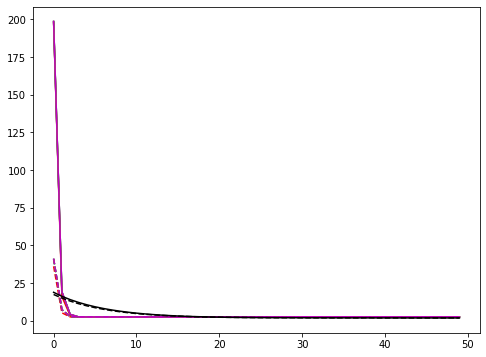

In [1]:
import os
import keras
import itertools

# 設定 GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""




train, test = keras.datasets.cifar10.load_data()




## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y   




x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)




# from keras import regularizers
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
# def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    
#     input_layer = keras.layers.Input(input_shape)
    
#     for i, n_units in enumerate(num_neurons):
#         if i == 0:
#             x = keras.layers.Dense(units=n_units, 
#                                    activation="relu", 
#                                    name="hidden_layer"+str(i+1), 
#                                    kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer) # regularization
#         else:
#             x = keras.layers.Dense(units=n_units, 
#                                    activation="relu", 
#                                    name="hidden_layer"+str(i+1),
#                                    kernel_regularizer=l1_l2(l1_l2_ratio))(x) # regularization
    
#     out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
#     model = keras.models.Model(inputs=[input_layer], outputs=[out])
#     return model

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer) # regularization
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x) # regularization
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
# L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]





# results = {}
# """
# 使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
# """
# for regulizer_ratio in L1_L2_EXP:
#     keras.backend.clear_session() # 把舊的 Graph 清掉
#     print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
#     model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
#     model.summary()
#     optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
#     model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

#     model.fit(x_train, y_train, 
#               epochs=EPOCHS, 
#               batch_size=BATCH_SIZE, 
#               validation_data=(x_test, y_test), 
#               shuffle=True)
    
#     # Collect results
#     train_loss = model.history.history["loss"]
#     valid_loss = model.history.history["val_loss"]
#     train_acc = model.history.history["acc"]
#     valid_acc = model.history.history["val_acc"]
    
#     exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
#     results[exp_name_tag] = {'train-loss': train_loss,
#                              'valid-loss': valid_loss,
#                              'train-acc': train_acc,
#                              'valid-acc': valid_acc}




results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc' : train_acc,
                             'valid-acc' : valid_acc}
    
    

# import matplotlib.pyplot as plt
# %matplotlib inline
# color_bar = ["r", "g", "b", "y", "m", "k"]

# plt.figure(figsize=(8,6))
# for i, cond in enumerate(results.keys()):
#     plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
#     plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
# plt.title("Loss")
# plt.ylim([0, 5])
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,6))
# for i, cond in enumerate(results.keys()):
#     plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
#     plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
# plt.title("Accuracy")
# plt.legend()
# plt.show()

In [5]:
results.keys()

dict_keys(['exp-l1-0.01-l2-0.01', 'exp-l1-0.01-l2-0.0001', 'exp-l1-0.01-l2-1e-08', 'exp-l1-0.01-l2-1e-12', 'exp-l1-0.01-l2-0.0', 'exp-l1-0.0001-l2-0.01', 'exp-l1-0.0001-l2-0.0001', 'exp-l1-0.0001-l2-1e-08', 'exp-l1-0.0001-l2-1e-12', 'exp-l1-0.0001-l2-0.0', 'exp-l1-1e-08-l2-0.01', 'exp-l1-1e-08-l2-0.0001', 'exp-l1-1e-08-l2-1e-08', 'exp-l1-1e-08-l2-1e-12', 'exp-l1-1e-08-l2-0.0', 'exp-l1-1e-12-l2-0.01', 'exp-l1-1e-12-l2-0.0001', 'exp-l1-1e-12-l2-1e-08', 'exp-l1-1e-12-l2-1e-12', 'exp-l1-1e-12-l2-0.0', 'exp-l1-0.0-l2-0.01', 'exp-l1-0.0-l2-0.0001', 'exp-l1-0.0-l2-1e-08', 'exp-l1-0.0-l2-1e-12', 'exp-l1-0.0-l2-0.0'])

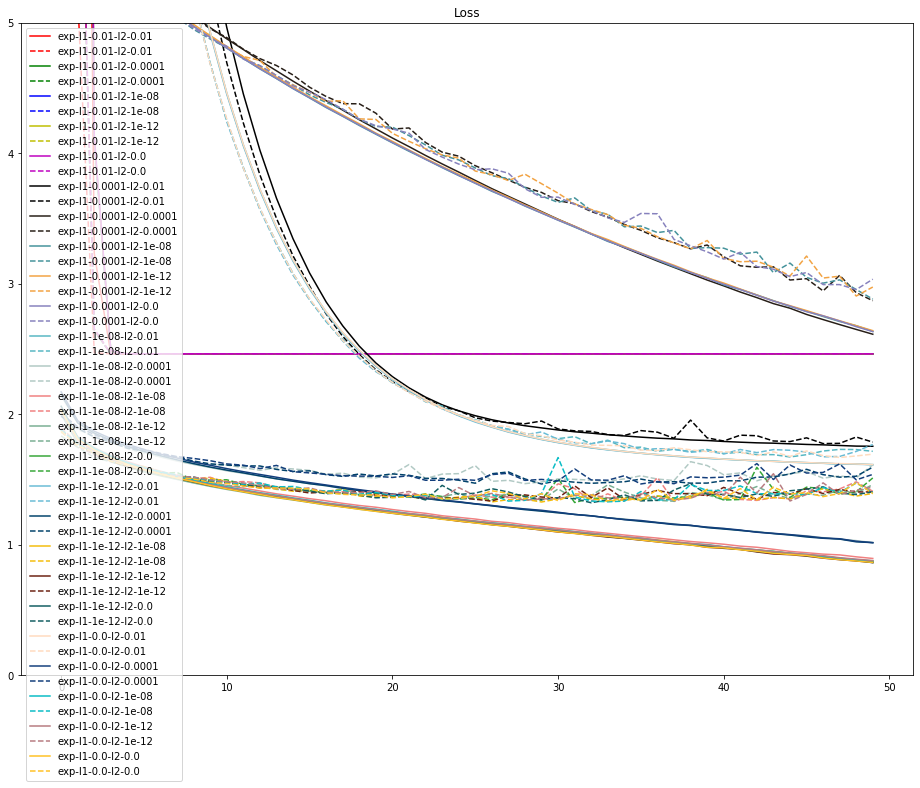

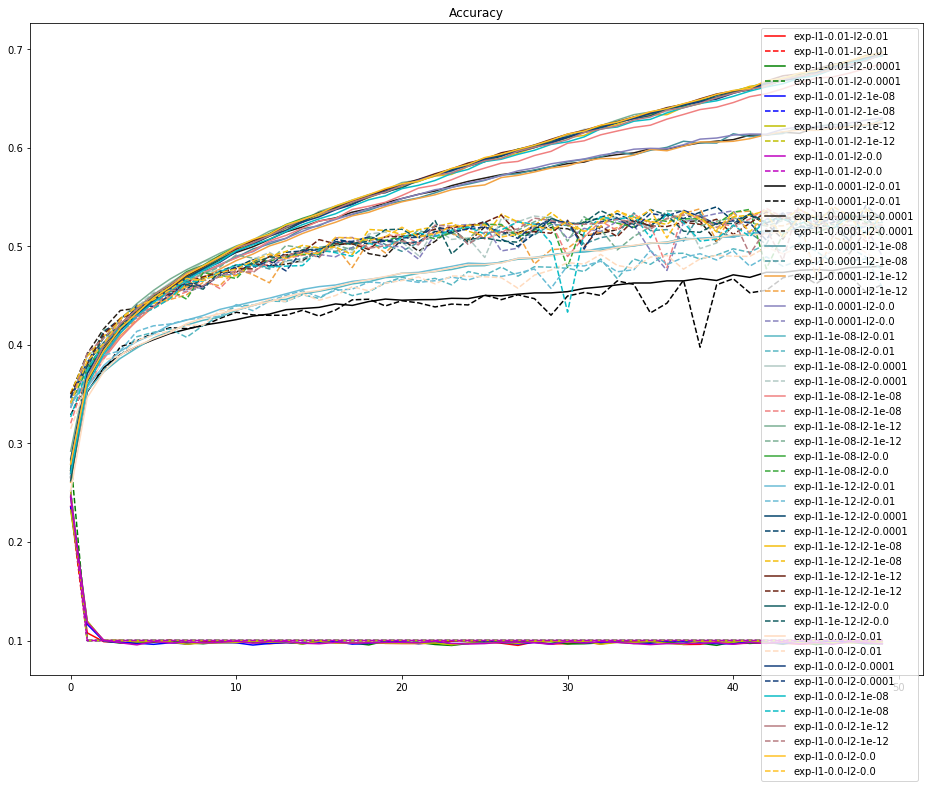

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# 因為 len(results.keys()) == 25 ，所以 color_bar 要 25 colors --> color hex
color_bar = ["r", "g", "b", "y", "m", 
             "k", "#271e17", "#44929b", "#f2a343", "#8681bd", 
             "#56b7c2", "#b1c9c4", "#f08080", "#79af92", "#36a738", 
             "#69bcd5", "#01426a", "#f4bd0c", "#6c2111", "#115d61", 
             "#ffdbbe", "#133e7c", "#0abdc6", "#b77c81", "#ffc125"]

plt.figure(figsize=(16, 12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(16, 12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 參考資料


Towards Data Science - Regularization in Machine Learning

在前面機器學習的課程中，已經提過 L1 與 L2 的原理與效果。

在深度學習模型中，Regularization 的參數是加在每一個 layer 中，最後在計算 loss 時，才會全部加起來併入 loss term。然而，實務經驗上，目前已經有很多更好避免參數權重過大導致神經網路不穩的方法如BatchNorm，在後面的課程中會陸續提到。

![img1](https://ai100-fileentity.cupoy.com/2nd/homework/D81/1563173943225/large)


## 參考連結：

## [Toward Data Science-Regularization in Machine Learning](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a)

## [Machine Learning Explained: Regularization](http://enhancedatascience.com/2017/07/04/machine-learning-explained-regularization/)

## [機器學習：正規化 by Murphy](https://murphymind.blogspot.com/2017/05/machine.learning.regularization.html)

